# WORKING WITH SHAPEFILES IN THE DOMIAN OF AGRICULTURE

Welcome to our tutorial about shapefiles. In this notebook you will learn:

- how to read shapefiles (https://en.wikipedia.org/wiki/Shapefile ),
- how transform geodata (i.e. from longitude/latitude to meters),
- how to calculate the area of a field.


Let's start by importing some libraries:

In [1]:
# to download the files
import zipfile
import urllib
# to read the files
import geopandas as gpd
import json
# to carry out (numerical and geometric) calculations
import numpy as np
import utm
import alphashape
# to plot the results
import matplotlib.pyplot as plt
from descartes import PolygonPatch

## 1) Download the data

Now, let's download some example data provided in Github. For simplicity, we save the data in the current working directory:

In [2]:
# download of the data
urllib.request.urlretrieve("https://github.com/JohnDeere/SampleData/raw/master/Shapefiles/Export%20From%20MyJohnDeere%20-%20Harvest.zip",
                           "Harvest.zip")
# unzip the data
with zipfile.ZipFile("Harvest.zip", 'r') as zip_ref:
    zip_ref.extractall()
print("download and unzip of data succesful")

download and unzip of data succesful


The your working directory should now contain a folder named "doc". In this folder you now have five files that look like this:
![Screenshot-Files](Screenshot-Files.png)

Note, that the \*.dbf and the \*.json file can be opened with any text editor (like Notepad, Notepad++, Gedit, and so on). Sometimes it is convenient to open the \*.json file by the editor to have a quick preview. Nevertheless, the other files cannot be read with a standard editor, that is why we need some code to read the shapefile.

## 2) Read and plot the data

As the filename may indicate we have a recording of a soyabeans harvest. Now, let's read the data we have unzipped above:

In [3]:
gdf = gpd.read_file("./doc/Merriweather Farms-JT-01-Soybeans.shp")
print("reading data succesful")

reading data succesful


Let's simply plot the location of the very first point in our dataset to get a vague idea where the field can be found:

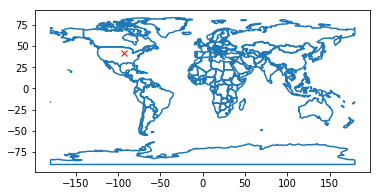

In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.boundary.plot();
plt.plot(gdf.geometry.x[0],gdf.geometry.y[0],"rx");

Looks like somewhere in the Mid-West Region of the USA.

Let's create a first plot of the data of the soyabeans harvest of the field itself:

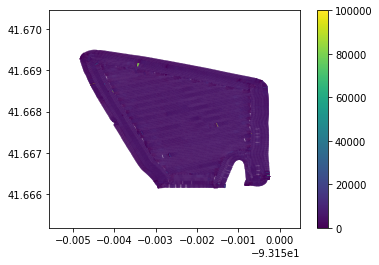

In [5]:
gdf.plot(column='WetMass', markersize=0.1, legend=True);

Well, this plot does not help much. In the following we will investigate the data more detailed.

## 3) Check the data

Let's print some information about the data:

In [6]:
print("length (number of row entries):")
print(len(gdf))
print("A snaphot of the first entries:")
gdf.head()

length (number of row entries):
40960
A snaphot of the first entries:


,DISTANCE,SWATHWIDTH,VRYIELDVOL,SECTIONID,Crop,WetMass,Moisture,Time,Heading,VARIETY,Elevation,IsoTime,geometry
0,0.034447,5.0,0.0,1260,174,0.0,4.56,9/19/2016 4:45:10 PM,286.148407,23A42,786.450003,2016-09-19T16:45:10.000Z,POINT Z (-93.15027 41.66636 0.00000)
1,0.034447,5.0,0.0,1261,174,0.0,4.56,9/19/2016 4:45:10 PM,286.148407,23A42,786.450003,2016-09-19T16:45:10.000Z,POINT Z (-93.15026 41.66637 0.00000)
2,0.034447,5.0,0.0,1262,174,0.0,4.56,9/19/2016 4:45:10 PM,286.148407,23A42,786.450003,2016-09-19T16:45:10.000Z,POINT Z (-93.15026 41.66639 0.00000)
3,0.034447,5.0,0.0,1263,174,0.0,4.56,9/19/2016 4:45:10 PM,286.148407,23A42,786.450003,2016-09-19T16:45:10.000Z,POINT Z (-93.15025 41.66640 0.00000)
4,0.034447,5.0,0.0,1264,174,0.0,4.56,9/19/2016 4:45:10 PM,286.148407,23A42,786.450003,2016-09-19T16:45:10.000Z,POINT Z (-93.15025 41.66641 0.00000)


That looks all good. The record wa done somewhen in September 2016 and the *geometry* column tells us exactly the position of the application. 

There is a lot of technical details in the table which we won't need at all. But in the following, most important for us will be the column *WetMass*. The interested reader may be referred to https://developer-portal.deere.com/#/myJohnDeereAPI/%2Fdocumentation%2Fmyjohndeere%2FshapefilesOverview.htm for more details about the contence of the other columns.

Note, we do not know yet if the *WetMass* was recorded recorded as volume (e.g. litres or galones) or as a mass (e.g. kilogram, tons or pounds). This information can be found in the \*.json file which contains the metadata (metadata means information about the data). 

Let's read the metadata from the \*.json file to see if there is information about the units used for the *WetMass*:

In [7]:
with open("./doc/Merriweather Farms-JT-01-Soybeans-Deere-Metadata.json", 'r') as f:
    metadata = json.load(f)
print(metadata)

{'Version': '1.0', 'OrgId': 223031, 'ClientId': '46234f43-0000-1000-4014-e1e1e11124e0', 'ClientName': 'Merriweather Farms', 'FarmId': '4641d448-0000-1000-4033-e1e1e11124e0', 'FarmName': 'JT', 'FieldId': 'e61b83f4-3a12-431e-8010-596f2466dc27', 'FieldName': '01', 'Operation': 'Harvest', 'CropSeason': 2016, 'CropToken': 'SOYBEANS', 'FileCreatedTimeStamp': '2018-04-25T21:08:48.9432Z', 'DataAttributes': [{'Name': 'DISTANCE', 'Unit': 'ft', 'Description': 'Distance Travelled From Previous Point'}, {'Name': 'SWATHWIDTH', 'Unit': 'ft', 'Description': 'Width Of Element'}, {'Name': 'VRYIELDVOL', 'Unit': 'bu1ac-1', 'Description': 'Yield as Volume'}, {'Name': 'SECTIONID', 'Description': 'Element Id'}, {'Name': 'Crop', 'Description': 'CropId'}, {'Name': 'Moisture', 'Unit': 'prcnt', 'Description': 'Moisture'}, {'Name': 'WetMass', 'Unit': 'lb1ac-1', 'Description': 'Wet Mass'}, {'Name': 'Time', 'Description': 'Timestamp'}, {'Name': 'Heading', 'Description': 'Machine Heading'}, {'Name': 'VARIETY', 'Desc

Of course, this looks confusing. Have you found it?

You can extract the relevant information of the units like this:

In [8]:
print("Get the metadata of colum number 6 (WetMass):")
print(metadata['DataAttributes'][6])
print("Get the units of the corresponding column:")
print(metadata['DataAttributes'][6]['Unit'])

Get the metadata of colum number 6 (WetMass):
{'Name': 'WetMass', 'Unit': 'lb1ac-1', 'Description': 'Wet Mass'}
Get the units of the corresponding column:
lb1ac-1


In this case we have pounds per acre, i.e. an average value of the *WetMass* for the area between two measurement points. 

Note, that in general the units may differ. For example, sometimes there are pounds and sometimes kilograms. Or sometimes acres and sometimes hectares. You never know unless you check the metadata.

**Hence, it is always necessary to check the \*.json file (or more generally speaking: the metadata) to do accurate calculations.**

It is not too difficult to transform the values from one unit to another. 

## 4) Transforming from longitude and latitude to meters

Up to now, have no idea about the size of the application. This is because the provided *geometry* points are provided in longitute and latitude. This is unconvenient to get an idea of the size of the field.

The *utm library* is a standard library to transform the *geometry* points from longitude/latitude to meters. Let's consider an example for the first point of the data:

In [9]:
x = gdf.geometry.x.values[0]
y = gdf.geometry.y.values[0]
# we must swap x and y here
my_Point = utm.from_latlon(y, x)

print("(EASTING, NORTHING, ZONE_NUMBER, ZONE_LETTER):")
print(my_Point)

(EASTING, NORTHING, ZONE_NUMBER, ZONE_LETTER):
(487490.2192514679, 4612744.570265312, 15, 'T')


The result provides four values, two numbers (in meters) and a number and a letter. In the following, we can ignore the ZONE_NUMBER and ZONE_LETTER (see https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system, only needed if we want to calculate back to longitude and latitude). 

Now, let's do this transformation for all points in the data and store them in a list:

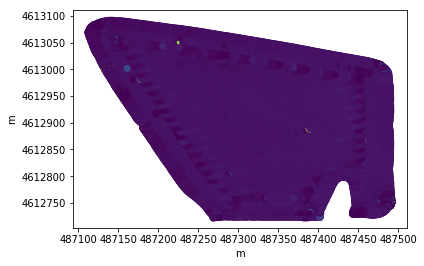

In [12]:
geometry_m = []
x = gdf.geometry.x.values
y = gdf.geometry.y.values
for i in range(len(x)):
    # add first 2 values only (from_latlon also delivers ZONE_NUMBER and ZONE_LETTER, see above)
    geometry_m.append(utm.from_latlon(y[i], x[i])[0:2])
plt.scatter(np.array(geometry_m)[:,0],np.array(geometry_m)[:,1],c=gdf.WetMass.values)
plt.xlabel('m')
plt.ylabel('m');

There we are: horizontally, we have about 400 meters  and vertically we also have about 400 meters again.

## 5) Calculate the area of a field

One application in agriculture might be to calculate the exact area of a field or an application. To do this, we need to get the boundary of the field in a first step. 

We can use the *alphashape library* (see also https://en.wikipedia.org/wiki/Alpha_shape ). If we set $\alpha =0$ we get the convex hull (https://en.wikipedia.org/wiki/Convex_hull ):

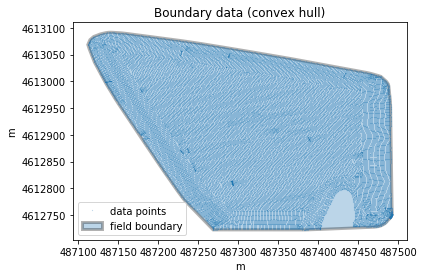

In [14]:
alpha = 0
boundary_points = alphashape.alphashape(geometry_m, alpha)
# plot the result
_, ax = plt.subplots()
plt.title('Boundary data (convex hull)')
plt.plot(np.array(geometry_m)[:,0],np.array(geometry_m)[:,1],".",markersize=0.2)
ax.add_patch(PolygonPatch(boundary_points, alpha=0.3, linewidth=3))
plt.legend(['data points','field boundary'])
plt.xlabel('m')
plt.ylabel('m');

That does not look bad. Now, the area can be calculated in one line of code:

In [17]:
area = boundary_points.area
print("area of the field: %.1f (square meters)" % area)

area of the field: 102337.6 (square meters)


Note, that we have a whole in the data at the lower right corner. Let's raise the $\alpha$ value in the alphashape library to get a more exact boundary. 

The following calculation will take a few seconds:

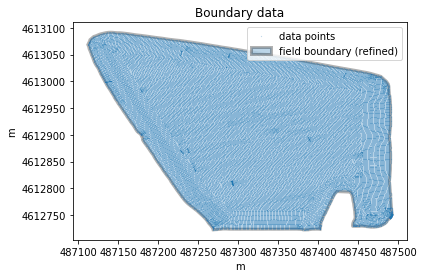

In [16]:
alpha = 0.1 # alpha must be non-negative
boundary_points = alphashape.alphashape(geometry_m, alpha)
# plot the result
_, ax = plt.subplots()
plt.title('Boundary data')
plt.plot(np.array(geometry_m)[:,0],np.array(geometry_m)[:,1],".",markersize=0.2)
# if alpha is chosen too large we will have no boundary
if not boundary_points.is_empty:
    ax.add_patch(PolygonPatch(boundary_points, alpha=0.3, linewidth=3))
plt.legend(['data points','field boundary (refined)'])
plt.xlabel('m')
plt.ylabel('m');

Again, the area can be calculated in one line of code:

In [17]:
area = boundary_points.area
print("area of the field: %.1f (square meters)" % area)

area of the field: 99380.9 (square meters)


## Summary

This introduction shows:

- how to read shapefiles,
- how to get the boundary of a field,
- how to calculate the area of a field.

This can be seen as a starting point for calculations in the research field of agriculture. Examples would be calculation of harvest mass, optimization of fertilisers and so on.

**Acknowledgements:** we thank John Deere for providing the data (https://github.com/JohnDeere/SampleData ).

**Contact:** https://www.iese.fraunhofer.de/en/competencies/data.html